### 正規化をしてテキストファイルに起こすノートブックです

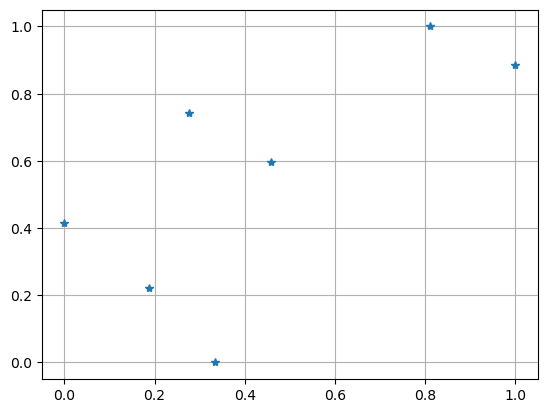

In [3]:
from self_pack import plot_points
from matplotlib import pyplot as plt
path = r'C:\Users\wtana\Desktop\LiDAR_cm\lidar_txt_files\wall_1.txt'
#plotの範囲を全部にするならxmin and xmax に-1
#normalizeするなら1
#しないなら0
x,y,no = normalize_points(path,xmin=-200,xmax=0,ymin=-500,ymax=-250,normalize=1)
#x,y,no = normalize_points(path,xmin=-1,xmax=-1,ymin=0,ymax=500,normalize=0)
plt.plot(x[6],y[6],linestyle='',marker='*')
plt.grid('TRUE')
#plt.xlim(-120,0)
#plt.savefig('../md_matome/images/tree_right_normalize.png')

In [9]:
s = ''
for i in range(len(x)):
    s = ''
    with open('./normalize_txt/wall/'+str(i)+'.txt','a') as f:
        for x_,y_ in zip(x[i],y[i]):
            s = s + str(x_) + ' ' + str(y_) + ' 95\n'
        f.write(s)

In [12]:
import glob
import random
file_path = './normalize_txt/wall/*'
files = glob.glob(file_path)
for idx,file in enumerate(files):
    f = open(file,'r')
    data = f.read().split('\n')
    f.close()
    f = open(file,'a')
    for _ in range(33 -len(data)):
        num = random.randint(0,len(data)-2)
        f.write(str(data[num])+'\n')
    f.close()